# Recommend System

Data : [MovieLens Latest Datasets](https://grouplens.org/datasets/movielens/latest/)

# Setting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import itertools

import os
import time
import math

# torch tools
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# visualization tools
from matplotlib import pyplot as plt, style
style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
from tqdm import tqdm

# warning control tool
from warnings import filterwarnings, simplefilter
filterwarnings('ignore')
simplefilter('ignore')

# Load Data & Data preprocessing

## Movies

**Info**

- `Action`
- `Adventure`
- `Animation`
- `Children`
- `Comedy`
- `Crime`
- `Documentary`
- `Drama`
- `Fantasy`
- `Film-Noir`
- `Horror`
- `Musical`
- `Mystery`
- `Romance`
- `Sci-Fi`
- `Thriller`
- `War`
- `Western`
- (no genres listed)

In [3]:
movies = pd.read_csv('/content/drive/MyDrive/ToBigs/RS/ml-latest-small 2/movies.csv')

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


**Movie genres 종류 확인하기**

In [5]:
movies['genres'].value_counts()

Drama                                                  1053
Comedy                                                  946
Comedy|Drama                                            435
Comedy|Romance                                          363
Drama|Romance                                           349
                                                       ... 
Action|Crime|Horror|Mystery|Thriller                      1
Adventure|Animation|Children|Comedy|Musical|Romance       1
Action|Adventure|Animation|Comedy|Crime|Mystery           1
Children|Comedy|Fantasy|Sci-Fi                            1
Action|Animation|Comedy|Fantasy                           1
Name: genres, Length: 951, dtype: int64

In [6]:
# list of genre
genre_dict = {}

for row in movies['genres'] : 
    parsed_genre = row.split("|")
    for genre_name in parsed_genre : 
        if (genre_name in genre_dict) == False :
        	genre_dict[genre_name] = 1
        else :
        	genre_dict[genre_name] = genre_dict[genre_name] + 1
                       
genre_dict

{'Adventure': 1263,
 'Animation': 611,
 'Children': 664,
 'Comedy': 3756,
 'Fantasy': 779,
 'Romance': 1596,
 'Drama': 4361,
 'Action': 1828,
 'Crime': 1199,
 'Thriller': 1894,
 'Horror': 978,
 'Mystery': 573,
 'Sci-Fi': 980,
 'War': 382,
 'Musical': 334,
 'Documentary': 440,
 'IMAX': 158,
 'Western': 167,
 'Film-Noir': 87,
 '(no genres listed)': 34}

**중복된 Movie 확인하기**

In [11]:
print(f"전체 영화의 개수 : {len(movies)}")
print(f"중복 제거한 영화의 개수 : {len(movies['movieId'].unique())}")

전체 영화의 개수 : 9742
중복 제거한 영화의 개수 : 9742


`Output`

중복된 Movie data는 없다.

## Links

In [12]:
links = pd.read_csv('/content/drive/MyDrive/ToBigs/RS/ml-latest-small 2/links.csv')

links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [13]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


## Ratings

In [79]:
ratings = pd.read_csv('/content/drive/MyDrive/ToBigs/RS/ml-latest-small 2/ratings.csv')

ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [15]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [16]:
ratings['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [17]:
# rating 평균과 표준편차
print('rating의 평균: ', ratings['rating'].mean().round(4))
print('rating의 표준편차: ', ratings['rating'].std().round(4))

rating의 평균:  3.5016
rating의 표준편차:  1.0425


## Tags

In [19]:
tags = pd.read_csv('/content/drive/MyDrive/ToBigs/RS/ml-latest-small 2/tags.csv')

tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [20]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [21]:
tag_count = tags['tag'].value_counts()

tag_count

In Netflix queue     131
atmospheric           36
thought-provoking     24
superhero             24
funny                 23
                    ... 
small towns            1
In Your Eyes           1
Lloyd Dobbler          1
weak plot              1
Heroic Bloodshed       1
Name: tag, Length: 1589, dtype: int64

`Output`

각 데이터에 대한 결측치는 없으나, `links` 데이터는 불필요해보인다.

## Derived Variable
- 파생변수

### 1. Merges movie and ratings

In [23]:
movie_rating = pd.DataFrame(ratings.groupby("movieId")["rating"].agg("count"))
movie_rating.reset_index(level = 0, inplace = True)

movie_rating

,movieId,rating
0,1,215
1,2,110
2,3,52
3,4,7
4,5,49
...,...,...
9719,193581,1
9720,193583,1
9721,193585,1
9722,193587,1


In [24]:
user_rating = pd.DataFrame(ratings.groupby("userId")["rating"].agg("count"))
user_rating.reset_index(level = 0, inplace = True)

user_rating

,userId,rating
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44
...,...,...
605,606,1115
606,607,187
607,608,831
608,609,37


In [25]:
# df2 = moives + ratings
df2 = pd.merge(movies, ratings)

df2

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021


In [26]:
df2.drop(["genres","timestamp"], axis = 1,inplace = True)

df2

,movieId,title,userId,rating
0,1,Toy Story (1995),1,4.0
1,1,Toy Story (1995),5,4.0
2,1,Toy Story (1995),7,4.5
3,1,Toy Story (1995),15,2.5
4,1,Toy Story (1995),17,4.5
...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),184,4.0
100832,193583,No Game No Life: Zero (2017),184,3.5
100833,193585,Flint (2017),184,3.5
100834,193587,Bungo Stray Dogs: Dead Apple (2018),184,3.5


In [27]:
# movie title pivot table
piv1 = df2.pivot_table(index='userId',columns='title',values='rating')

piv1

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


In [28]:
piv1.fillna(0, inplace = True)

piv1

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.5,3.5,0.0,0.0,0.0


In [30]:
# userID pivot table
piv2 = pd.pivot(index = "movieId", columns = "userId", data = ratings, values = "rating")

piv2

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
piv2.fillna(0, inplace = True)

piv2

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
# final dataset
# df_mr = movies + ratings
df_mr = piv2.loc[movie_rating[movie_rating["rating"] > 10]["movieId"],:]
df_mr = df_mr.loc[:, user_rating[user_rating["rating"] > 60]["userId"]]

df_mr

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2. Average rating of each movie genre

In [177]:
df_movie = pd.merge(movies, ratings, left_on = 'movieId', right_on = 'movieId')

df_movie

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021


In [170]:
# 'Drama' average rating
a1 = df_movie['genres'].str.contains('Drama')
df_drama = df_movie[a1]

df_drama

,movieId,title,genres,userId,rating,timestamp
377,4,Waiting to Exhale (1995),Comedy|Drama|Romance,6,3.0,845554349
378,4,Waiting to Exhale (1995),Comedy|Drama|Romance,14,3.0,835441653
379,4,Waiting to Exhale (1995),Comedy|Drama|Romance,84,3.0,858772461
380,4,Waiting to Exhale (1995),Comedy|Drama|Romance,162,3.0,836684306
381,4,Waiting to Exhale (1995),Comedy|Drama|Romance,262,1.0,840306203
...,...,...,...,...,...,...
100821,190213,John From (2015),Drama,338,1.0,1530148478
100822,190215,Liquid Truth (2017),Drama,338,1.5,1530148477
100827,193567,anohana: The Flower We Saw That Day - The Movi...,Animation|Drama,184,3.0,1537099103
100828,193571,Silver Spoon (2014),Comedy|Drama,184,4.0,1537099392


In [173]:
a = df_drama['rating'].mean()

a

3.6561844113718758

In [178]:
# 'comedy' average rating
b1 = df_movie['genres'].str.contains('Comedy')
df_comedy = df_movie[b1]

df_comedy

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...
100826,193565,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,184,3.5,1537098554
100828,193571,Silver Spoon (2014),Comedy|Drama,184,4.0,1537099392
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545


In [180]:
b = df_comedy['rating'].mean()

b

3.3847207640898267

In [184]:
# 'Western' average rating
c1 = df_movie['genres'].str.contains('Western')
df_western = df_movie[c1]

df_western

,movieId,title,genres,userId,rating,timestamp
4722,163,Desperado (1995),Action|Romance|Western,1,5.0,964983650
4723,163,Desperado (1995),Action|Romance|Western,6,3.0,845553907
4724,163,Desperado (1995),Action|Romance|Western,18,4.0,1455748933
4725,163,Desperado (1995),Action|Romance|Western,34,3.0,1162050915
4726,163,Desperado (1995),Action|Romance|Western,38,1.0,841341715
...,...,...,...,...,...,...
100048,162350,The Magnificent Seven (2016),Action|Western,414,2.5,1513958742
100049,162350,The Magnificent Seven (2016),Action|Western,596,4.0,1535709670
100050,162350,The Magnificent Seven (2016),Action|Western,610,3.5,1493849971
100433,171759,The Beguiled (2017),Drama|Thriller|Western,50,3.0,1514240171


In [185]:
c = df_western['rating'].mean()

c

3.583937823834197

In [186]:
# 'Musical' average rating
d1 = df_movie['genres'].str.contains('Musical')
df_musical = df_movie[d1]

df_musical 

,movieId,title,genres,userId,rating,timestamp
2310,48,Pocahontas (1995),Animation|Children|Drama|Musical|Romance,19,1.0,965709172
2311,48,Pocahontas (1995),Animation|Children|Drama|Musical|Romance,20,5.0,1054038357
2312,48,Pocahontas (1995),Animation|Children|Drama|Musical|Romance,21,3.0,1376822924
2313,48,Pocahontas (1995),Animation|Children|Drama|Musical|Romance,27,4.0,962685318
2314,48,Pocahontas (1995),Animation|Children|Drama|Musical|Romance,38,3.0,841341570
...,...,...,...,...,...,...
97962,118997,Into the Woods (2014),Children|Comedy|Fantasy|Musical,556,4.0,1534321209
97963,118997,Into the Woods (2014),Children|Comedy|Fantasy|Musical,563,4.0,1440800320
97964,118997,Into the Woods (2014),Children|Comedy|Fantasy|Musical,567,1.0,1525289397
98488,126482,Strange Magic (2015),Animation|Children|Fantasy|Musical,382,3.0,1515248933


In [187]:
d = df_musical['rating'].mean()

d

3.5636781053649105

# EDA

### 1. 사람들은 어떤 장르를 선호할까?

- 장르별 시청수 비교하기



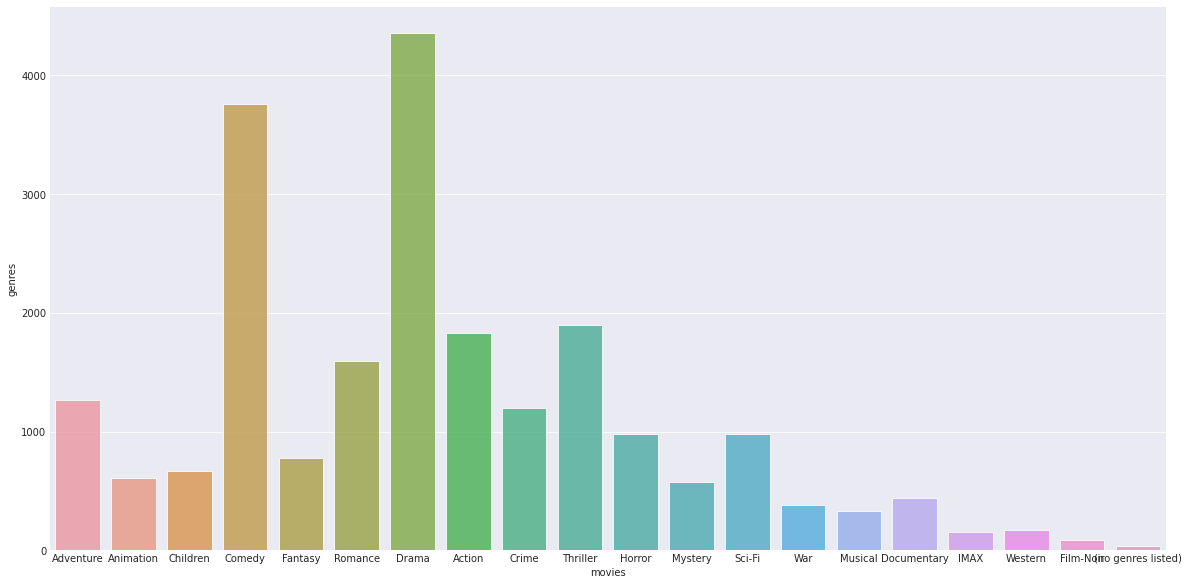

In [40]:
# genres graph
N, M =20, 10
fig, ax = plt.subplots(figsize=(N, M))

x = list(genre_dict.keys())
y = list(genre_dict.values())

sns.barplot(x, y, alpha=0.8)
plt.xlabel("movies")
plt.ylabel("genres")

plt.show()

`Output`

사람들은 `Drama`와 `Comedy` 관련 장르를 많이 시청했으나, `Film-Noir` 관련 장르 영화 시청수는 낮다.

### 2. 사람들은 어떤 평점을 가장 많이 줬을까?
- 측정된 평점별 개수 확인하기

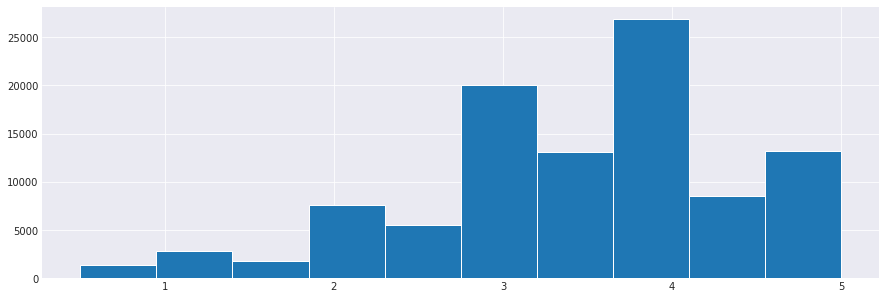

In [119]:
plt.figure(figsize=(15,5))

ratings.rating.hist()

`Output`

사람들은 `Drama`와 `Comedy` 관련 장르를 많이 시청했으나, `Film-Noir` 관련 장르 영화 시청수는 낮다.

### 3. 선호하는 장르일수록 평점이 높을까?
- 각 장르별 평균 평점 비교하기

In [ ]:
x = np.arange(3)

genres = [a, b, c, d]
values = [a, b, c, d]

plt.figure(figsize=(15,5))
plt.bar(x, values)
plt.xticks(x, years)

plt.show()

`Output`

사람들은 `Drama`와 `Comedy` 관련 장르를 많이 시청했으나, `Film-Noir` 관련 장르 영화 시청수는 낮다.

### 4. 어떤 User가 가장 평가를 많이 했을까?
- User별 평가수 확인하기


`Output`

사람들은 `Drama`와 `Comedy` 관련 장르를 많이 시청했으나, `Film-Noir` 관련 장르 영화 시청수는 낮다.

# Modeling & Evaluation

## Memory based CF
- KNN

1. 데이터 준비하기

In [120]:
# csr matrix
from scipy.sparse import csr_matrix

csr_data = csr_matrix(df_mr.values)
df_mr.reset_index(inplace=True)

csr_data

<2121x335 sparse matrix of type '<class 'numpy.float64'>'
	with 72787 stored elements in Compressed Sparse Row format>

In [128]:
piv3 = df2.pivot_table('rating', index = 'userId', columns = 'movieId')

piv3

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
piv3 = piv3.fillna(0)

piv3

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2. 코사인 유사도 구하기

In [130]:
# cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
cosine = pd.DataFrame(cosine_similarity(piv3))

cosine

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,1.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
1,0.027283,1.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
2,0.059720,0.000000,1.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
3,0.194395,0.003726,0.002251,1.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
4,0.129080,0.016614,0.005020,0.128659,1.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,1.000000,0.153063,0.262558,0.069622,0.201104
606,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,1.000000,0.283081,0.149190,0.139114
607,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,1.000000,0.121993,0.322055
608,0.093572,0.027565,0.000000,0.032198,0.261232,0.214234,0.090840,0.423993,0.000000,0.021766,...,0.035653,0.335231,0.061941,0.236601,0.097610,0.069622,0.149190,0.121993,1.000000,0.053225


In [132]:
cosine.index = piv3.index
cosine.columns = piv3.index

cosine

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
2,0.027283,1.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
3,0.059720,0.000000,1.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
4,0.194395,0.003726,0.002251,1.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
5,0.129080,0.016614,0.005020,0.128659,1.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,1.000000,0.153063,0.262558,0.069622,0.201104
607,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,1.000000,0.283081,0.149190,0.139114
608,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,1.000000,0.121993,0.322055


3. KNN 가져오기

In [44]:
# KNN
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

### User based CF

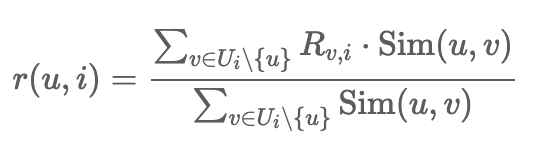

In [138]:
def user_based(userId):

    Id = userId
    idx = cosine[Id].sort_values(ascending = False)[1:10].index.values
    viewed_list = df2[df2['userId']==Id]['movieId'].values
    new_movie = []

    for i in idx:
        other_viewed_list = df2[df2['userId']==i].sort_values(by = 'rating', ascending = False)['movieId'].values
        for j in other_viewed_list:
            if j not in viewed_list:
                new_movie.append(j)
    
    for k in range(len(new_movie)):
        if k == 0 :
            recommend = movies[movies['movieId']==new_movie[k]]
        else :
            recommend = pd.concat([recommend, movies[movies['movieId']==new_movie[k]]])

    result = recommend[:10]
    
    return result

In [140]:
user_based(434)

,movieId,title,genres
6276,47610,"Illusionist, The (2006)",Drama|Fantasy|Mystery|Romance
413,475,In the Name of the Father (1993),Drama
922,1221,"Godfather: Part II, The (1974)",Crime|Drama
1243,1653,Gattaca (1997),Drama|Sci-Fi|Thriller
6170,44665,Lucky Number Slevin (2006),Crime|Drama|Mystery
5110,8132,Gladiator (1992),Action|Drama
2462,3275,"Boondock Saints, The (2000)",Action|Crime|Drama|Thriller
4118,5903,Equilibrium (2002),Action|Sci-Fi|Thriller
6557,54997,3:10 to Yuma (2007),Action|Crime|Drama|Western
6534,54286,"Bourne Ultimatum, The (2007)",Action|Crime|Thriller


`Output`

User based recommend system 결과, `User 434`에게 추천된 10개의 movie list는 다음과 같다.

### Item based CF

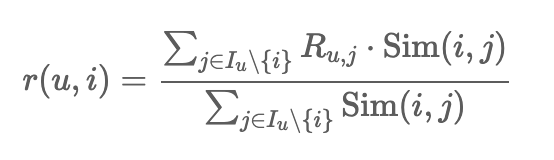

In [51]:
def item_based(movie_name):
    
    n_movies_to_reccomend = 10
    movie_list = movies[movies['title'].str.contains(movie_name)] # Fint movie name
    
    if len(movie_list):
        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = df_mr[df_mr['movieId'] == movie_idx].index[0]
        
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        
        for val in rec_movie_indices:
            movie_idx = df_mr.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Correlation':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    
    else:
        return "No movies found. Please check your input"

In [73]:
# recommend result
item_based('Jurassic Park')

,Title,Correlation
1,Aladdin (1992),0.329313
2,"Fugitive, The (1993)",0.328515
3,Batman (1989),0.327701
4,Speed (1994),0.313140
5,Mission: Impossible (1996),0.308919
6,Toy Story (1995),0.306580
7,Braveheart (1995),0.298873
8,Forrest Gump (1994),0.266877
9,Independence Day (a.k.a. ID4) (1996),0.251815
10,Terminator 2: Judgment Day (1991),0.249738


`Output`

Item based recommend system 결과, `Jurassic Park`와 가장 연관이 깊은 영화는 `Aladdin`다.

## Model based CF


### Clustering-based Algorithm
- KNN


0. 세팅하기

In [63]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 9.7 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633971 sha256=5d4064ba19e8ad82d74032506c0db73c779b3936d0e6726d6e64eef4dba821cd
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [149]:
# settings
import surprise

from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import accuracy
from surprise import Reader
from surprise import SVD
from surprise.dataset import DatasetAutoFolds

1. 데이터 준비하기

In [152]:
# load data
reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [153]:
# split data
trainset, testset = train_test_split(data, test_size=0.2, random_state=0)

trainset

2. 사용자의 평점 예측하기
- `User 434`

In [154]:
user = str(434)
item = str(77)

In [146]:
# SVD
algo = SVD(n_factors=50, random_state=0)

algo.fit(trainset)

In [155]:
# predict ratings
pred = algo.predict(user, item, verbose=True)

user: 434        item: 77         r_ui = None   est = 3.50   {'was_impossible': False}


`Output`

`User 434`가 `movieID 77`에 대한 평점이 없으므로, 예상 평점을 3.50으로 예측했다.

3. 해당 User가 보지 않은 영화 개수 구하기

In [159]:
def get_unseen_surprise(ratings, movies, userId):
    seen_movies = ratings[ratings['userId']== userId]['movieId'].tolist()

    total_movies = movies['movieId'].tolist()

    unseen_movies = [ movie for movie in total_movies if movie not in seen_movies]

    total_movie_cnt = len(total_movies)
    seen_cnt = len(seen_movies)
    unseen_cnt = len(unseen_movies)
    
    print(f"전체 영화 개수: {total_movie_cnt}, 평점을 매긴 영화 개수: {seen_cnt}, 추천 대상 영화 개수: {unseen_cnt}")
    
    return unseen_movies

In [160]:
unseen_movies = get_unseen_surprise(ratings, movies, 434)

전체 영화 개수: 9742, 평점을 매긴 영화 개수: 233, 추천 대상 영화 개수: 9509


`Output`

`User 434`는 총 233개의 영화를 평가했고, 나머지 9509개의 영화 중에서 추천할 수 있다.

4. Surprise recommend model

In [167]:
def surprise(algo, userId, unseen_movies, top_n=10):
  
    predictions = []    
    for movieId in unseen_movies:
        predictions.append(algo.predict(str(userId), str(movieId)))

    def sortkey_est(pred):
        return pred.est

    predictions.sort(key=sortkey_est, reverse=True) 

    top_predictions = predictions[:top_n]

    print(f"Top-{top_n} Recommend Movies")
    
    for pred in top_predictions:
        
        movie_id = int(pred.iid)
        movie_title = movies[movies["movieId"] == movie_id]["title"].tolist()
        movie_rating = pred.est

        print(f"{movie_title}: {movie_rating:.2f}")

5. 추천 결과 출력하기

In [168]:
surprise(algo, 434, unseen_movies, top_n=10)

Top-10 Recommend Movies
['Grumpier Old Men (1995)']: 3.50
['Waiting to Exhale (1995)']: 3.50
['Father of the Bride Part II (1995)']: 3.50
['Sabrina (1995)']: 3.50
['Tom and Huck (1995)']: 3.50
['Sudden Death (1995)']: 3.50
['American President, The (1995)']: 3.50
['Dracula: Dead and Loving It (1995)']: 3.50
['Balto (1995)']: 3.50
['Nixon (1995)']: 3.50


`Output`

Surprise recommend model 결과, `User 434`에게 추천된 10개의 movie list는 다음과 같다.

6. 성능 평가하기

In [162]:
predictions = algo.test(testset)

In [163]:
# evaluation
accuracy.rmse(predictions)

RMSE: 0.8669


0.8668986463958782

### Deep Learning
- Stacked Autoencoder



In [87]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'GPU device name: {torch.cuda.get_device_name()}')

GPU device name: Tesla T4


1. 데이터 준비하기

In [95]:
# movieId 따로 뽑기
nb_movies = ratings['movieId'].nunique()

nb_movies

9724

In [98]:
# userId 따로 뽑기
nb_users = ratings['userId'].nunique()

nb_users

610

In [84]:
# creating data 1
ratings_matrix = ratings.pivot_table(index=['userId'], columns=['movieId'], values='rating').reset_index(drop=True)
ratings_matrix.fillna(0, inplace=True)

ratings_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
606,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
# creating data 2
data_matrix = np.array(ratings_matrix)

print(data_matrix.shape)
print(data_matrix)

(610, 9724)
[[4.  0.  4.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [2.5 2.  2.  ... 0.  0.  0. ]
 [3.  0.  0.  ... 0.  0.  0. ]
 [5.  0.  0.  ... 0.  0.  0. ]]


In [88]:
data_matrix_torch = torch.FloatTensor(data_matrix).to(device)

2. Stacked Autoencoder model

In [96]:
# model
class SAE(nn.Module):
    def __init__(self, ):
        super(SAE, self).__init__()
        self.fc1 = nn.Linear(nb_movies, 50)
        self.fc2 = nn.Linear(50, 10)
        self.fc3 = nn.Linear(10, 50)
        self.fc4 = nn.Linear(50, nb_movies)
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x
    
    def prediction(self, x):
        pred = self.forward(x)
        return pred.detach().numpy()
    
model = SAE().to(device)

criterion = nn.MSELoss() # evaluation

optimizer = optim.RMSprop(model.parameters(), lr=0.01, weight_decay=0.5)

In [97]:
# Model Summary
from torchsummary import summary

summary(model, (610, 9724))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 610, 50]         486,250
           Sigmoid-2              [-1, 610, 50]               0
            Linear-3              [-1, 610, 10]             510
           Sigmoid-4              [-1, 610, 10]               0
            Linear-5              [-1, 610, 50]             550
           Sigmoid-6              [-1, 610, 50]               0
            Linear-7            [-1, 610, 9724]         495,924
Total params: 983,234
Trainable params: 983,234
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 22.63
Forward/backward pass size (MB): 46.28
Params size (MB): 3.75
Estimated Total Size (MB): 72.66
----------------------------------------------------------------


3. 모델 훈련하기

In [99]:
from torch.autograd import Variable

In [100]:
# training model
nb_epoch = 100
save_train_loss = []
epoch_num = []

min_train_loss = 1000
forgive = 30
forgive_count = 0

model.train()
torch.backends.cudnn.benchmark = True
for epoch in range(1, nb_epoch + 1):
    train_loss = 0
    steps = 0
    for id_user in range(nb_users):
        input = Variable(data_matrix_torch[id_user]).unsqueeze(0)
        target = input.clone()
        if torch.sum(target.data > 0) > 0:
            output = model(input)
            target.require_grad = False
            output[target == 0] = 0
            loss = criterion(output, target)
            mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)
            loss.backward()
            train_loss += np.sqrt((loss.data * mean_corrector).cpu())
            steps += 1
            optimizer.step()

    epoch_train_loss = (train_loss/steps).item()
    if epoch%10 == 0:
        print(f'epoch #{str(epoch)} loss: {epoch_train_loss:.5f}')

    
    if min_train_loss >= (train_loss/steps).item():
        min_train_loss = (train_loss/steps).item()
        forgive_count = 0
    elif min_train_loss < (train_loss/steps).item():
        forgive_count += 1
    
    save_train_loss.append(epoch_train_loss)
    epoch_num.append(epoch)

    if forgive_count > forgive:
        print('Early stopping initiated')
        print('-'*25)
        print(f'epoch #{str(epoch)} loss: {epoch_train_loss:.5f}')
        break

epoch #10 loss: 1.12937
epoch #20 loss: 1.02836
epoch #30 loss: 0.99141
epoch #40 loss: 0.97255
epoch #50 loss: 0.96164
epoch #60 loss: 0.95491
epoch #70 loss: 0.95068
epoch #80 loss: 0.94796
epoch #90 loss: 0.94619
epoch #100 loss: 0.94501


4. 추천 결과 출력하기

In [107]:
ind_matrix = np.zeros((nb_users, nb_movies))
ind_matrix = np.where(data_matrix == 0, 1, 0)

pred = np.multiply(data_matrix_pred_SAE, ind_matrix)ㅌ

temp = []
top10 = []

# 각 user당 top 10 movie list 만들기
for person in range(nb_users):
    flag = False
    for rating in reversed(range(1,6)):
        for idx in range(len(pred[0])):
            if pred[person][idx] == rating:
                temp.append(idx)
                if len(temp) == 10:
                    top10.append(temp)
                    temp = []
                    flag = True
                    break
        if flag:
            break

In [115]:
# recommend result
user_id = np.random.randint(1,643)
movie_recommend = movies[movies['movieId'].isin(top10[user_id-1])]
movie_recommend = movie_recommend.style.set_caption(f'Possible Top 10 Movies for User {user_id}')

movie_recommend

,movieId,title,genres
42,46,How to Make an American Quilt (1995),Drama|Romance
44,48,Pocahontas (1995),Animation|Children|Drama|Musical|Romance
78,87,Dunston Checks In (1996),Children|Comedy
95,107,Muppet Treasure Island (1996),Adventure|Children|Comedy|Musical
350,405,Highlander III: The Sorcerer (a.k.a. Highlander: The Final Dimension) (1994),Action|Fantasy
502,583,Dear Diary (Caro Diario) (1994),Comedy|Drama
563,680,"Alphaville (Alphaville, une étrange aventure de Lemmy Caution) (1965)",Drama|Mystery|Romance|Sci-Fi|Thriller
577,708,"Truth About Cats & Dogs, The (1996)",Comedy|Romance


`Output`

Stacked Autoencoder model 결과, 랜덤으로 뽑은 `User 434`에게 추천된 10개의 movie list는 다음과 같다. 앞서 User based recommend system 추천 결과와 많이 다르다는 것을 알 수 있다.

5. 성능 평가하기
- training loss graph

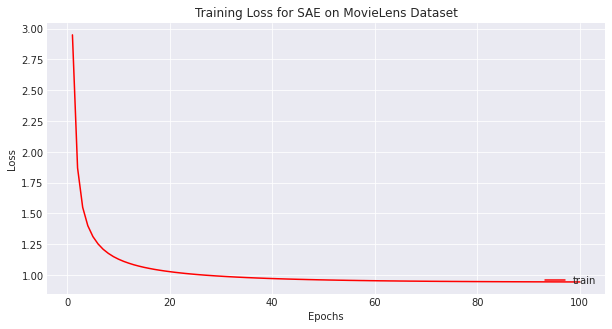

In [102]:
# training loss
plt.plot(epoch_num, save_train_loss, 'r', label='train')
plt.title('Training Loss for SAE on MovieLens Dataset')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.rcParams['figure.figsize'] = [20, 10]

plt.show()

- RSME

In [103]:
# SAE prediction
predict_SAE = np.zeros((nb_users, nb_movies))

for id_user in range(nb_users):
    input = Variable(data_matrix_torch[id_user]).unsqueeze(0)
    predict_SAE[id_user] = model.cpu().prediction(input.cpu())

data_matrix_pred_SAE = np.where(data_matrix == 0, predict_SAE, data_matrix)

for i in range(data_matrix_pred_SAE.shape[0]):
    for j in range(data_matrix_pred_SAE.shape[1]):
        data_matrix_pred_SAE[i, j] = round(data_matrix_pred_SAE[i, j])

X_pred = np.zeros((nb_users, nb_movies))
for i in range(predict_SAE.shape[0]):
    for j in range(predict_SAE.shape[1]):
        X_pred[i, j] = round(predict_SAE[i, j])

In [104]:
# 원본 rating 
print("Original Rating Matrix: \n", data_matrix)

Original Rating Matrix: 
 [[4.  0.  4.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [2.5 2.  2.  ... 0.  0.  0. ]
 [3.  0.  0.  ... 0.  0.  0. ]
 [5.  0.  0.  ... 0.  0.  0. ]]


In [105]:
# Stacked Auto-Encoder 적용한 후 rating
print("Rating Matrix after Applying Stacked Auto-Encoder: \n", data_matrix_pred_SAE)

Rating Matrix after Applying Stacked Auto-Encoder: 
 [[4. 4. 4. ... 3. 3. 3.]
 [4. 4. 3. ... 3. 3. 3.]
 [4. 4. 3. ... 3. 3. 3.]
 ...
 [2. 2. 2. ... 3. 3. 3.]
 [3. 4. 3. ... 3. 3. 3.]
 [5. 4. 3. ... 3. 3. 3.]]


In [106]:
# RMSE
ind_matrix = np.zeros((nb_users, nb_movies))
ind_matrix = np.where(data_matrix != 0, 1, 0)

x = np.multiply(X_pred, ind_matrix)
RMSE_SAE = np.sqrt(np.mean((x - data_matrix)**2))
print("RMSE of SAE Model is %f." %RMSE_SAE)

RMSE of SAE Model is 0.122746.
